In [1]:
import pandas as pd
import matplotlib as mpl
from mplsoccer.pitch import Pitch
from matplotlib.colors import to_rgba
import numpy as np
from mplsoccer.statsbomb import read_event, EVENT_SLUG
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colorbar
from matplotlib.colors import LinearSegmentedColormap
from highlight_text import fig_text
import math

In [2]:
#load in csv straight from konklone download
df = pd.read_csv("cadizA.csv")

#filter for only actions by the team you want
OneTeam = df.loc[(df['teamId']==65)]

#Make a new, single column for time and sort the events in chronological order
OneTeam["newsecond"] = 60*OneTeam["minute"]+OneTeam["second"]

OneTeam.sort_values(by=['newsecond'])

#identify the passer and then the recipient, who'll be the playerId of the next action
OneTeam['passer'] = OneTeam['playerId']

OneTeam['recipient'] = OneTeam['passer'].shift(-1)

#filter for only passes and then successful passes
Passes = OneTeam.loc[(OneTeam['type/displayName']=="Pass")]

Completions = Passes.loc[(Passes['outcomeType/displayName']=="Successful")]

#find time of the team's first substitution and filter the df to only passes before that
Subs = OneTeam.loc[(OneTeam['type/displayName']=="SubstitutionOff")]
SubTimes = Subs["newsecond"]
SubOne = SubTimes.min()

pas = pd.to_numeric(Completions['passer'],downcast='integer')
rec = pd.to_numeric(Completions['recipient'],downcast='integer')

Completions['passer'] = pas
Completions['recipient'] = rec

SubTimes
#SubOne

<ipython-input-2-c261180a6b40>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OneTeam["newsecond"] = 60*OneTeam["minute"]+OneTeam["second"]
<ipython-input-2-c261180a6b40>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OneTeam['passer'] = OneTeam['playerId']
<ipython-input-2-c261180a6b40>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

831     2700.0
833     2700.0
1386    4613.0
1388    4620.0
Name: newsecond, dtype: float64

In [3]:
Completions = Completions.loc[Completions['newsecond'] < SubOne]

In [4]:
#Find Average Locations 
average_locs_and_count = Completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean','count']})
average_locs_and_count.columns = ['x', 'y', 'count']

In [5]:
average_locs_and_count

,x,y,count
passer,,,
1,11.909091,53.745455,11
2,59.751852,13.781481,27
5,58.153846,43.124615,65
7,67.060870,52.378261,23
9,64.040000,47.900000,5
10,72.439394,42.987879,33
14,67.692683,75.090244,41
15,45.817778,67.222222,45
18,59.742593,82.407407,54


In [6]:
#find number of passes along each 'path' of passer to recipient
passes_between = Completions.groupby(['passer', 'recipient']).id.count().reset_index()
passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='recipient', right_index=True,
                                      suffixes=['', '_end'])

In [7]:
passes_between.dtypes

passer          int64
recipient       int64
pass_count      int64
x             float64
y             float64
count           int64
x_end         float64
y_end         float64
count_end       int64
dtype: object

In [8]:
size=1000
radius = math.sqrt(size)/2.
arrow = mpl.patches.FancyArrowPatch(posA=(1.2*passes_between.x,80-.8*passes_between.y), 
                                    posB=(1.2*passes_between.x_end,80-.8*passes_between.y_end), 
                                    arrowstyle='-|>', mutation_scale=20, shrinkA=radius, shrinkB=radius)


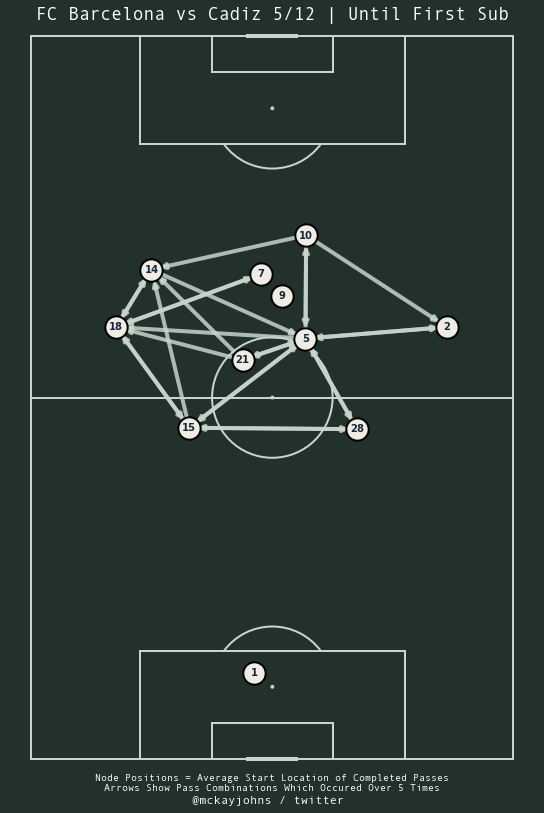

In [11]:
#set minimum threshold for pass arrows to be plotted. So this will only plot combos which occured at least 5 times.
passes_between = passes_between.loc[(passes_between['pass_count']>5)]


#Make arrows less transparent if they have a higher count, totally optional of course
min_transparency = 0.3
color = np.array(to_rgba('#d3d3d3'))
color = np.tile(color, (len(passes_between), 1))
c_transparency = passes_between.pass_count / passes_between.pass_count.max()
c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
color[:, 3] = c_transparency

#plot pitch
pitch = Pitch(pitch_type='statsbomb', orientation='vertical',
              pitch_color='#22312b', line_color='#c7d5cc', figsize=(16, 11),
              constrained_layout=True, tight_layout=False)
fig, ax = pitch.draw()


#plot arrows
def pass_line_template(ax, x, y, end_x, end_y, line_color):
    ax.annotate('', xy=(80-.8*end_y, 1.2*end_x), xytext=(80-.8*y, 1.2*x), zorder=1,
    arrowprops=dict(arrowstyle='-|>', linewidth=4, color='#c7d5cc', alpha=.85))
    
def pass_line_template_shrink(ax, x, y, end_x, end_y, line_color, dist_delta=1.2):
    dist = math.hypot(end_x - x, end_y - y)
    angle = math.atan2(end_y-y, end_x-x)
    upd_x = x + (dist - dist_delta) * math.cos(angle)
    upd_y = y + (dist - dist_delta) * math.sin(angle)
    pass_line_template(ax, x, y, upd_x, upd_y, line_color=line_color)
    
    
for index, row in passes_between.iterrows():
    pass_line_template_shrink(ax,row['x'],row['y'],row['x_end'],row['y_end'],'white')

''' 
pass_arrows = pitch.arrows(1.2*passes_between.x, 80-0.8*passes_between.y,
                         1.2*passes_between.x_end, 80-0.8*passes_between.y_end, width=5,
                         headwidth=5, headlength=5, color=color, ax=ax, zorder=1)

size=1000
radius = math.sqrt(size)/2.
arrow = mpl.patches.FancyArrowPatch(posA=(1.2*passes_between.x,80-.8*passes_between.y), 
                                    posB=(1.2*passes_between.x_end,80-.8*passes_between.y_end), 
                                    arrowstyle='-|>', mutation_scale=20, shrinkA=radius, shrinkB=radius)

ax.add_patch(arrow)
 '''
#plot nodes
pass_nodes = pitch.scatter(1.2*average_locs_and_count.x, 80-0.8*average_locs_and_count.y, s=500,
                           color='#f0ece2', edgecolors="#010101", linewidth=2, alpha=1, ax=ax, zorder=2)


#anootation/key at bottom
pitch.annotate("Node Positions = Average Start Location of Completed Passes\nArrows Show Pass Combinations Which Occured Over 5 Times", (-4, 40), color='w',
               fontsize=10, ha='center', va='center', ax=ax, fontweight='bold', fontfamily="Andale Mono")


#Uncomment these next two lines to get each node labeled with the player id. Check to see if anything looks off, and make note of each player if you're going to add labeles later like their numbers
for index, row in average_locs_and_count.iterrows():
     pitch.annotate(row.name, xy=(1.2*row.x, 80-0.8*row.y), c='#132743', va='center', ha='center', size=10, fontweight='bold', fontfamily="Century Gothic",ax=ax)

#Set the background color
fig.patch.set_facecolor('#22312b')

#annotatios
ax.set_title("FC Barcelona vs Cadiz 5/12 | Until First Sub", fontsize=18, color="w", fontfamily="Andale Mono", fontweight='bold', pad=-8)
fig.text(.43,-.01,f'@mckayjohns / twitter',fontstyle='italic',fontsize=12,fontfamily='Andale Mono',color='w')

#save the plot
plt.savefig('cadiz.png', dpi = 500, bbox_inches='tight',facecolor='#22312b')